<a href="https://colab.research.google.com/github/pankajchandra24/Cricket/blob/main/Assignment_Decimal_Cricket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Pick a world T20 team using any current players from any country giving justification. When the team and the batting order is selected, workout to find chances of each of the players to become the highest run scorer if they batted first against England at Oval.**



*   Collected data from cricsheet for all the T20I matches from 2018 till now. Only matches betweeen top 12 ranking teams are considered.
*   Using criteria for a balanced team, built a team.
*   Compared their performance attributes against England.
*   Since 2018, there has not been a T20I at oval, therefore domestic competition 'T20 Blast' data for Kennington Oval is considered to determine ground attributes.
*   To evaluate the expected bowling standards of England at Oval, second innings bowling data for Surrey County is used.
*   Finally, once expected runs_per_ball and avg_ball_faced by each player is calculated, Monte-Carlo simulations are run to find the probabilities for highest run scorer.







**1. Importing Libraries**

In [65]:
import pandas as pd
import os
import math
import numpy as np
import io
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

**2. Collecting T20I data from Cricsheet.org**

In [66]:
#Cricsheet URL
cricsheet_url= "https://cricsheet.org/downloads/t20s_male_csv2.zip"
#Folder name where the files will be stored
folder_name= cricsheet_url.split('/')[-1].split('.zip')[0]
#Storing the zip file as a variable
zip_file=cricsheet_url.split('/')[-1]
#Get the zip file from the URL, pass the URL as a parameter
! wget -q "$cricsheet_url"
#Make a directory with a desired folder name
! mkdir -p "$folder_name"
#Unzip all the files downloaded and store in the desired directory. "qq" is used to not print the output for each of the extractions
! unzip -o -qq "$zip_file" -d "$folder_name"
#Discard the actual zip file
! rm "$zip_file"
#delete all the csv files which has "_info" in them in the folder "t20s_male_csv2".
# list of all CSV files in the folder
csv_files = [f for f in os.listdir(folder_name) if f.endswith('.csv')]
# Iterate over the CSV files and delete those with "_info" in their name
for file in csv_files:
  if "_info" in file:
    os.remove(os.path.join(folder_name, file))
# combine all the csv files in one dataframe named "all_matches"
# list of all CSV files in the folder
csv_files = [os.path.join(folder_name, f) for f in os.listdir(folder_name) if f.endswith('.csv')]
# empty list to store the dataframes
dataframes = []
# Iterate over the CSV files and read them into dataframes
for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)
# Concatenate all the dataframes into one
all_matches = pd.concat(dataframes, ignore_index=True)
all_matches.head(3)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,1298149,2022/23,2022-10-23,"Bellerive Oval, Hobart",1,0.1,Ireland,Sri Lanka,PR Stirling,A Balbirnie,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1298149,2022/23,2022-10-23,"Bellerive Oval, Hobart",1,0.2,Ireland,Sri Lanka,A Balbirnie,PR Stirling,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1298149,2022/23,2022-10-23,"Bellerive Oval, Hobart",1,0.3,Ireland,Sri Lanka,A Balbirnie,PR Stirling,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**3. Considering matches between top 12 teams and dividing them in phases such as Powerplay, Middle overs and Death Overs**

In [67]:
#list of top 12 countries found in column "batting_team" which has top 12 corresponding occurences
# count the occurrences of each unique value in the "batting_team" column
country_counts = all_matches['batting_team'].value_counts()
# top 12 countries
top_12_countries = country_counts.head(12)
# remove all the rows from the dataframe "all_matches" which doesn't include these top countries in both the columns "batting_team and "bowling team"
# filter the dataframe to include only rows where both 'batting_team' and 'bowling_team' are in the list of top 12 countries
filtered_matches = all_matches[(all_matches['batting_team'].isin(top_12_countries.index)) & (all_matches['bowling_team'].isin(top_12_countries.index))]
# filter the dataframe to include only rows with 'start_date' greater than or equal to '2018-01-01'
filtered_matches = filtered_matches[filtered_matches['start_date'] >= '2018-01-01']
# Reset the index of the dataframe
filtered_matches = filtered_matches.reset_index(drop=True)
# replace all missing values with zero
filtered_matches.fillna(0, inplace=True)
# delete all the rows where innings value is greater than 2 which represents super over
df1 = filtered_matches[filtered_matches['innings'] <= 2]
# add the Phase Column with entries Powerplay, Middle and Death
def add_phase_column(df1):
  df1['phase'] = np.select(
      [df1['ball'] < 6.1, (df1['ball'] >= 6.1) & (df1['ball'] < 15.1)],
      ['Powerplay', 'Middle'],
      default='Death')
  return df1
df1 = add_phase_column(df1)
df1.head(3)

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed,phase
0,1298149,2022/23,2022-10-23,"Bellerive Oval, Hobart",1,0.1,Ireland,Sri Lanka,PR Stirling,A Balbirnie,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,Powerplay
1,1298149,2022/23,2022-10-23,"Bellerive Oval, Hobart",1,0.2,Ireland,Sri Lanka,A Balbirnie,PR Stirling,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,Powerplay
2,1298149,2022/23,2022-10-23,"Bellerive Oval, Hobart",1,0.3,Ireland,Sri Lanka,A Balbirnie,PR Stirling,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,Powerplay


**4. Batting statistics are calculated for different phases of the game**

In [68]:
# Create a new dataframe "batting_stats"
batting_stats = pd.DataFrame(columns=['Striker', 'phase', 'runs_off_bat', 'balls_faced', 'dismissed', 'boundary_counts', 'dot_balls'])
# Iterate over the unique striker names in the 'striker' column
for striker in df1['striker'].unique():
    # Filter the dataframe to include only rows where the striker is the given striker
    striker_df = df1[df1['striker'] == striker]
    striker_df_dis = df1[(df1['striker'] == striker) | (df1['non_striker'] == striker)]
    # Iterate over the unique phases in the 'phase' column
    for phase in striker_df['phase'].unique():
        # Filter the striker dataframe to include only rows where the phase is the given phase
        phase_df = striker_df[striker_df['phase'] == phase]
        phase_df_dis = striker_df_dis[striker_df_dis['phase'] == phase]
        # Count the number of times the striker or non-striker (when the given striker is at non strike) was dismissed in the given phase
        dismissed = (phase_df_dis['player_dismissed'] == striker).sum()
        # Calculate the runs scored by the striker in the given phase
        runs_off_bat = phase_df['runs_off_bat'].sum()
        # Calculate the balls faced by the striker in the given phase, excluding wides
        balls_faced = phase_df[phase_df['wides'] == 0]['ball'].count()
        # Calculate the boundary counts
        boundary_counts = phase_df[(phase_df['runs_off_bat'] == 4) | (phase_df['runs_off_bat'] == 6)]['runs_off_bat'].count()
        # Calculate the dot balls
        dot_balls = phase_df[(phase_df['runs_off_bat'] == 0) & (phase_df['wides'] == 0)]['runs_off_bat'].count()
        # Add a new row to the "batting_stats" dataframe with the striker's name, phase, runs scored, balls faced, dismissals, boundary counts, and dot balls
        batting_stats = batting_stats.append({'Striker': striker, 'phase': phase, 'runs_off_bat': runs_off_bat, 'balls_faced': balls_faced, 'dismissed': dismissed, 'boundary_counts': boundary_counts, 'dot_balls': dot_balls}, ignore_index=True)
# Print the "batting_stats" dataframe
batting_stats.head(3)


,Striker,phase,runs_off_bat,balls_faced,dismissed,boundary_counts,dot_balls
0,PR Stirling,Powerplay,911,654,36,150,307
1,PR Stirling,Middle,333,235,14,43,74
2,PR Stirling,Death,57,27,0,8,7


**5. Finding top 30 batsmen, 10 from each of the three phases on the basis of runs scored, then calculating different batting parameters, scaling it to build a rating system to compare these 30 batsmen and finally, choosing 5 top rated batsmen from each phase, don't be confused if you see boundary ratio = 1, this means the batsman had the highest boundary ratio, since after scaling with the max value of the column, it becomes 1. I tried other standardization methods like Z score or max-min normalization, but it didn't prove to be helpful**

In [69]:
#trim the data frame batting_stats to only 30 strikers, 10 from each phase corresponding to highest runs_off_bat.
# Sort the batting_stats dataframe by 'runs_off_bat' in descending order
batting_stats_sorted = batting_stats.sort_values(by='runs_off_bat', ascending=False)
# Get the top 10 strikers from each phase
top_10_powerplay = batting_stats_sorted[batting_stats_sorted['phase'] == 'Powerplay'].head(10)
top_10_middle = batting_stats_sorted[batting_stats_sorted['phase'] == 'Middle'].head(10)
top_10_death = batting_stats_sorted[batting_stats_sorted['phase'] == 'Death'].head(10)
# Concatenate the top 10 strikers from each phase into a single dataframe
top_30_strikers = pd.concat([top_10_powerplay, top_10_middle, top_10_death], ignore_index=True)
# in top_30_strikers, add 5 columns, "average" is ratio of 'runs_off_bat' to 'dismissed', "strike_rate" is the ratio of  'runs_off_bat' to 'balls_faced', "boundary_ratio" is ratio of 'boundary_counts' to  'balls_faced', "dot_ball_ratio" is the ratio of 'dot_balls' to  'balls_faced', "Avg_balls_faced" is ratio of 'balls_faced' to 'number of dismissal'
# Calculate the average runs per dismissal
top_30_strikers['average'] = top_30_strikers['runs_off_bat'] / top_30_strikers['dismissed']
# Calculate the strike rate
top_30_strikers['strike_rate'] = (top_30_strikers['runs_off_bat'] / top_30_strikers['balls_faced']) * 100
# Calculate the boundary ratio
top_30_strikers['boundary_ratio'] = top_30_strikers['boundary_counts'] / top_30_strikers['balls_faced']
# Calculate the dot ball ratio
top_30_strikers['dot_ball_ratio'] = top_30_strikers['dot_balls'] / top_30_strikers['balls_faced']
# Calculate the average balls faced per dismissal
top_30_strikers['Avg_balls_faced'] = top_30_strikers['balls_faced'] / top_30_strikers['dismissed']
# Create a copy of the top_30_strikers dataframe
top_30_strikers_scaled = top_30_strikers.copy()
# Define the columns to be scaled
columns_to_scale = ['average', 'strike_rate', 'boundary_ratio', 'dot_ball_ratio', 'Avg_balls_faced']
# Iterate over the unique phases
for phase in top_30_strikers['phase'].unique():
    # Filter the dataframe to include only rows where the phase is the given phase
    phase_df = top_30_strikers_scaled[top_30_strikers_scaled['phase'] == phase]
    # Scaling by dividing all the values of the columns with the max value
    for column in columns_to_scale:
        phase_df[column] = (phase_df[column]  / phase_df[column].max())
        top_30_strikers_scaled.loc[top_30_strikers_scaled['phase'] == phase, ['average', 'strike_rate', 'boundary_ratio', 'dot_ball_ratio', 'Avg_balls_faced']] = phase_df[['average', 'strike_rate', 'boundary_ratio', 'dot_ball_ratio', 'Avg_balls_faced']]
# Add a new column, striker's rating, dependent on different phase, calculated using dot product of columns ['average', 'strike_rate', 'boundary_ratio', 'dot_ball_ratio', 'Avg_balls_faced'] with weights manually mentioned for the three different phases.
# Define the weights for each column in each phase
weights = {
    'Powerplay': {'average': 0, 'strike_rate': 1.3, 'boundary_ratio': 1.3, 'dot_ball_ratio': 0, 'Avg_balls_faced': 0},
    'Middle': {'average': 1.3, 'strike_rate': 1.1, 'boundary_ratio': 1.1, 'dot_ball_ratio': -1.3, 'Avg_balls_faced': 1.2},
    'Death': {'average': 1.1, 'strike_rate': 1.3, 'boundary_ratio': 1.3, 'dot_ball_ratio': -1.1, 'Avg_balls_faced': 1.05}
}
# Create a new column 'rating' in the dataframe
top_30_strikers_scaled['rating'] = 0
# Iterate over the unique phases
for phase in top_30_strikers_scaled['phase'].unique():
     #Filter the dataframe to include only rows where the phase is the given phase
    phase_df = top_30_strikers_scaled[top_30_strikers_scaled['phase'] == phase]
     #Calculate the rating for each striker in the given phase
    phase_df['rating'] = phase_df[['average', 'strike_rate', 'boundary_ratio', 'dot_ball_ratio', 'Avg_balls_faced']].mul(weights[phase]).sum(axis=1)
    # Update the 'rating' column in the main dataframe
    top_30_strikers_scaled.loc[top_30_strikers_scaled['phase'] == phase, 'rating'] = phase_df['rating']
#  list of 5 top rated batters in each phase.
# Group the dataframe by phase and select the top 5 players based on 'rating'
top_5_strikers = top_30_strikers_scaled.groupby('phase').apply(lambda x: x.nlargest(5, 'rating'))
# Reset the index to make the phase a column
top_5_strikers = top_5_strikers.reset_index(drop=True)
# Print the top 5 players dataframe
top_5_strikers

,Striker,phase,runs_off_bat,balls_faced,dismissed,boundary_counts,dot_balls,average,strike_rate,boundary_ratio,dot_ball_ratio,Avg_balls_faced,rating
0,V Kohli,Death,638,321,12,87,73,1.0,0.845275,0.696391,0.720679,0.994088,3.355212
1,DA Miller,Death,552,296,11,73,64,0.943859,0.793103,0.633681,0.685192,1.0,3.189352
2,SA Yadav,Death,435,185,13,72,40,0.629371,1.0,1.0,0.685192,0.528846,3.093885
3,GJ Maxwell,Death,427,209,11,68,64,0.730123,0.868889,0.835991,0.970416,0.706081,2.693407
4,Najibullah Zadran,Death,475,250,15,71,77,0.595611,0.808046,0.729722,0.976056,0.619369,2.230947
5,Babar Azam,Middle,1448,1095,23,150,250,1.0,0.810093,0.628069,0.586359,0.994149,3.312691
6,Mohammad Rizwan,Middle,1105,862,18,95,186,0.9751,0.7853,0.505297,0.554171,1.0,3.166864
7,SA Yadav,Middle,1190,729,25,159,196,0.756077,1.0,1.0,0.690504,0.60891,3.015936
8,V Kohli,Middle,899,729,18,77,176,0.793316,0.755462,0.484277,0.620045,0.845708,2.603815
9,GD Phillips,Middle,1005,685,22,119,206,0.725609,0.898785,0.796502,0.772351,0.650179,2.584267


**6. Similar dataframe for top 5 bowlers from each phase is built**

In [70]:
# Create a new dataframe "bowling_stats" with the required columns
bowling_stats = pd.DataFrame(columns=['Bowler', 'phase', 'runs_conceded', 'balls_bowled', 'dots_bowled', 'wickets_taken'])
# Iterate over the unique bowler names in the 'bowler' column
for bowler in df1['bowler'].unique():
    # Filter the dataframe to include only rows where the bowler is the given bowler
    bowler_df = df1[df1['bowler'] == bowler]
    # Iterate over the unique phases in the 'phase' column
    for phase in bowler_df['phase'].unique():
        # Filter the bowler dataframe to include only rows where the phase is the given phase
        phase_df1 = bowler_df[bowler_df['phase'] == phase]
        # Calculate the runs conceded by the bowler in the given phase
        runs_conceded = phase_df1['runs_off_bat'].sum() + phase_df1['extras'].sum() - phase_df1['byes'].sum() - phase_df1['legbyes'].sum()
        # Calculate the balls bowled by the bowler in the given phase
        balls_bowled = phase_df1[(phase_df1['wides'] == 0) & (phase_df1['noballs'] == 0)]['ball'].count()
        # Calculate the dots bowled by the bowler in the given phase
        dots_bowled = phase_df1[(phase_df1['runs_off_bat'] < 1 ) & (phase_df1['wides'] < 1 ) & (phase_df1['noballs'] < 1)]['ball'].count()
        # Calculate the wickets taken by the bowler in the given phase
        wickets_taken = phase_df1[(phase_df1['wicket_type'] != 'hit wicket') & (phase_df1['wicket_type'] != 'retired hurt') & (phase_df1['wicket_type'] != 'run out') & (phase_df1['wicket_type'] != 0)]['wicket_type'].count()
        # Add a new row to the "bowling_stats" dataframe with the bowler's name, phase, runs conceded, balls bowled, dots bowled, and wickets taken
        bowling_stats = bowling_stats.append({'Bowler': bowler, 'phase': phase, 'runs_conceded': runs_conceded, 'balls_bowled': balls_bowled, 'dots_bowled': dots_bowled, 'wickets_taken': wickets_taken}, ignore_index=True)
# trim the data frame bowling_stats to only 30 bowlers, 10 from each phase corresponding to highest wickets_taken.
# Sort the bowling_stats dataframe by 'wickets_taken' in descending order
bowling_stats_sorted = bowling_stats.sort_values(by='wickets_taken', ascending=False)
# Get the top 10 bowlers from each phase
top_10_powerplay = bowling_stats_sorted[bowling_stats_sorted['phase'] == 'Powerplay'].head(10)
top_10_middle = bowling_stats_sorted[bowling_stats_sorted['phase'] == 'Middle'].head(10)
top_10_death = bowling_stats_sorted[bowling_stats_sorted['phase'] == 'Death'].head(10)
# Concatenate the top 10 bowlers from each phase into a single dataframe
top_30_bowlers = pd.concat([top_10_powerplay, top_10_middle, top_10_death], ignore_index=True)
# Calculate the economy rate
top_30_bowlers['economy'] = (6 * top_30_bowlers['runs_conceded']) / top_30_bowlers['balls_bowled']
# Calculate the balls per wicket ratio
top_30_bowlers['ballsperwicket'] = top_30_bowlers['balls_bowled'] / top_30_bowlers['wickets_taken']
# Calculate the runs per wicket ratio
top_30_bowlers['runsperwicket'] = top_30_bowlers['runs_conceded'] / top_30_bowlers['wickets_taken']
# Calculate the dots ratio
top_30_bowlers['dots_ratio'] = top_30_bowlers['dots_bowled'] / top_30_bowlers['balls_bowled']
# Create a copy of the top_30_bowlers dataframe
top_30_bowlers_scaled = top_30_bowlers.copy()
# Define the columns to be standardized
columns_to_scale = ['economy', 'ballsperwicket', 'runsperwicket', 'dots_ratio']
# Iterate over the unique phases
for phase in top_30_bowlers['phase'].unique():
    # Filter the dataframe to include only rows where the phase is the given phase
    phase_df = top_30_bowlers_scaled[top_30_bowlers_scaled['phase'] == phase]
    # Scaling the columns with the max value within the column
    for column in columns_to_scale:
        phase_df[column] = (phase_df[column]/ phase_df[column].max())
        top_30_bowlers_scaled.loc[top_30_bowlers_scaled['phase'] == phase, ['economy', 'ballsperwicket', 'runsperwicket', 'dots_ratio']] = phase_df[['economy', 'ballsperwicket', 'runsperwicket', 'dots_ratio']]
# Add a new column, bowler's rating, dependent on different phase, calculated using dot product of columns ['economy', 'ballsperwicket', 'runsperwicket', 'dots_ratio'] with weights manually mentioned for the three different phases.
# Define the weights for each column in each phase
weights = {
    'Powerplay': {'economy': 1.3, 'ballsperwicket': 1.3, 'runsperwicket': 1.1, 'dots_ratio': -1.3},
    'Middle': {'economy': 1.5, 'ballsperwicket': 1.3, 'runsperwicket': 1.2, 'dots_ratio': -1.3},
    'Death': {'economy': 1.5, 'ballsperwicket': 1.1, 'runsperwicket': 1.1, 'dots_ratio': -1.1}
}
# Create a new column 'rating' in the dataframe
top_30_bowlers_scaled['rating'] = 0
# Iterate over the unique phases
for phase in top_30_bowlers_scaled['phase'].unique():
    # Filter the dataframe to include only rows where the phase is the given phase
    phase_df = top_30_bowlers_scaled[top_30_bowlers_scaled['phase'] == phase]
    # Calculate the rating for each bowler in the given phase
    phase_df['rating'] = phase_df[['economy', 'ballsperwicket', 'runsperwicket', 'dots_ratio']].mul(weights[phase]).sum(axis=1)
    # Update the 'rating' column in the main dataframe
    top_30_bowlers_scaled.loc[top_30_bowlers_scaled['phase'] == phase, 'rating'] = phase_df['rating']
# from top_30_bowlers_scaled, find 5 bowlers from each phase that has the lowest ratings
# Group the dataframe by phase and select the top 5 players based on 'rating'
top_5_bowlers = top_30_bowlers_scaled.groupby('phase').apply(lambda x: x.nsmallest(5, 'rating'))
# Reset the index to make the phase a column
top_5_bowlers = top_5_bowlers.reset_index(drop=True)
# Print the top 5 players dataframe
top_5_bowlers

,Bowler,phase,runs_conceded,balls_bowled,dots_bowled,wickets_taken,economy,ballsperwicket,runsperwicket,dots_ratio,rating
0,Rashid Khan,Death,381.0,342,141,43,0.632613,0.504741,0.345213,1.0,0.783868
1,J Little,Death,373.0,242,88,31,0.875251,0.495409,0.468789,0.882012,1.403282
2,Haris Rauf,Death,805.0,583,209,49,0.784091,0.755063,0.640074,0.86953,1.754304
3,Shaheen Shah Afridi,Death,593.0,413,149,34,0.815349,0.770871,0.679526,0.875071,1.855883
4,Arshdeep Singh,Death,513.0,311,103,30,0.93669,0.657885,0.666234,0.803311,1.977923
5,Kuldeep Yadav,Middle,506.0,506,235,44,0.749474,0.527706,0.411579,1.0,1.004123
6,Rashid Khan,Middle,790.0,804,299,40,0.736423,0.922338,0.706842,0.800752,2.110907
7,PWH de Silva,Middle,1108.0,960,341,57,0.865018,0.772841,0.695697,0.764832,2.142775
8,T Shamsi,Middle,1422.0,1176,417,68,0.906251,0.793583,0.748421,0.763504,2.296585
9,Shadab Khan,Middle,1773.0,1475,551,70,0.900893,0.966914,0.906496,0.804345,2.650475


**7. Selecting the World T20 XI according to the ratings for different phase of the game. 5 proper Batsmen (openers: explosive and right left combination; middle order: stability providers; death: quick run getters), two all-rounders (one spin, other medium pacer), two wrist spinners (one righty, other lefty) and two fast bowlers (one righty, other lefty)**

In [71]:
#From top_5_strikers and top_5_bowlers, and Hardik was selected because he was the only top rated alrounder found in the list, following is the team selected
team = ['RG Sharma','Q de Kock','V Kohli','Babar Azam',
 'SA Yadav','GJ Maxwell','HH Pandya','Rashid Khan','Shaheen Shah Afridi','Kuldeep Yadav','JR Hazlewood']
team

['RG Sharma',
 'Q de Kock',
 'V Kohli',
 'Babar Azam',
 'SA Yadav',
 'GJ Maxwell',
 'HH Pandya',
 'Rashid Khan',
 'Shaheen Shah Afridi',
 'Kuldeep Yadav',
 'JR Hazlewood']

**8. Kennington Oval ground has not hosted any T20I since 2018, therefore T20 Blast domestic competition data is collected and filtered for Oval ground statistics, such as average balls faced by batsmen at different batting position position from 1 to 11. Also, for each player in the team, calculating performance attributes against England. Finally, applying weights to different performance indicators to get expected runs per ball and adjusted ball faced**

In [74]:
#Cricsheet URL
cricsheet_url_blast= "https://cricsheet.org/downloads/ntb_male_csv2.zip"
#Folder Name where the files will be stored
folder_name1= cricsheet_url_blast.split('/')[-1].split('.zip')[0]
#Storing the zip file as a variable
zip_file1=cricsheet_url_blast.split('/')[-1]
#Get the zip file from the URL, pass the URL as a parameter
! wget -q "$cricsheet_url_blast"
#Make a directory with a desired folder name
! mkdir -p "$folder_name1"
#Unzip all the files downloaded and store in the desired directory. "qq" is used to not print the output for each of the extractions
! unzip -o -qq "$zip_file1" -d "$folder_name1"
#Discard the actual zip file
! rm "$zip_file1"
#Retrieving ball by ball data for all the T20 Blast Matches
all_matches_blast = pd.read_csv(os.path.join('/content/ntb_male_csv2', "all_matches.csv"))
# Filter the dataframe to include only rows with 'start_date' greater than or equal to '2018-01-01'
all_matches_blast_last5yrs = all_matches_blast[all_matches_blast['start_date'] >= '2018-01-01']
# Reset the index of the dataframe
all_matches_blast_last5yrs  = all_matches_blast_last5yrs.reset_index(drop=True)
# only those rows which has venue 'Kennington Oval, London' or ''Kennington Oval'
matches_oval = all_matches_blast_last5yrs[all_matches_blast_last5yrs['venue'].isin(['Kennington Oval, London', 'Kennington Oval'])]
# only those rows where innings = 1 and bowling team is 'Surrey'
surrey_bowlfirst = matches_oval[(matches_oval['innings'] == 1) & (matches_oval['bowling_team'] == 'Surrey')]
# fill all the null values with 0
surrey_bowlfirst = surrey_bowlfirst.fillna(0)
# new dataframe for ground oval
Ground_Analysis = surrey_bowlfirst.copy()
# replacing names in the striker columns with batting positions
Ground_Analysis['striker'] = Ground_Analysis.groupby('match_id')['striker'].transform(lambda x: x.factorize()[0] + 1)
# average balls faced by each batting position
Ground_Analysis_Avg_balls_faced = Ground_Analysis.groupby(['match_id', 'striker'])['ball'].count().groupby('striker').mean()
# finding performance attributes batting first for each player
bat_first = df1[df1['innings'] == 1]
# new dataframe for Player Details (first innings performance)
Player_details = pd.DataFrame(columns=['Player', 'average', 'avg_balls_faced', 'avg_against_Eng', 'balls_faced_against_Eng'])
for player in team:
    player_df = bat_first[bat_first['striker'] == player]
    player_df_eng = bat_first[(bat_first['striker'] == player) & (bat_first['bowling_team'] == 'England')]
    average = player_df['runs_off_bat'].sum() / player_df['player_dismissed'].astype(bool).sum()
    avg_ball_faced = player_df[player_df['wides'] == 0]['ball'].count() / player_df['player_dismissed'].astype(bool).sum()
    avg_against_Eng = player_df_eng['runs_off_bat'].sum() / player_df_eng['player_dismissed'].astype(bool).sum()
    balls_faced_against_Eng = player_df_eng[player_df_eng['wides'] == 0]['ball'].count() / player_df_eng['player_dismissed'].astype(bool).sum()
    Player_details = Player_details.append({'Player': player, 'average': average, 'avg_balls_faced':  avg_ball_faced, 'avg_against_Eng': avg_against_Eng, 'balls_faced_against_Eng': balls_faced_against_Eng}, ignore_index=True)
Player_details['Oval_balls_faced_position'] = [Ground_Analysis_Avg_balls_faced[i] for i in range(1, 12)]
# replace Nan or inf  values to be zero
Player_details = Player_details.replace([np.nan, np.inf], 0)
# weighting the performance attributes and finding expected runs per ball, and adjusted ball faced by each player
Player_details['avg_adj'] = 0.75 * Player_details['average'] + 0.25 * Player_details['avg_against_Eng']
Player_details['avg_balls_faced_adj'] = 0.70 * Player_details['avg_balls_faced'] + 0.15 * Player_details['balls_faced_against_Eng'] + 0.15 * Player_details['Oval_balls_faced_position']
Player_details['Exp_runs_per_ball'] = Player_details['avg_adj'] / Player_details['avg_balls_faced_adj']
Player_details

,Player,average,avg_balls_faced,avg_against_Eng,balls_faced_against_Eng,Oval_balls_faced_position,avg_adj,avg_balls_faced_adj,Exp_runs_per_ball
0,RG Sharma,35.700000,24.450000,25.428571,19.142857,19.391304,33.132143,22.895124,1.447127
1,Q de Kock,29.333333,20.851852,24.000000,16.625000,20.739130,28.000000,20.200916,1.386076
2,V Kohli,37.535714,27.035714,51.200000,37.800000,19.478261,40.951786,27.516739,1.488250
3,Babar Azam,40.128205,31.512821,48.111111,35.222222,16.000000,42.123932,29.742308,1.416297
4,SA Yadav,42.068966,23.931034,31.400000,17.600000,14.590909,39.401724,21.580361,1.825814
5,GJ Maxwell,27.782609,17.130435,16.000000,13.500000,17.000000,24.836957,16.566304,1.499245
6,HH Pandya,30.444444,21.481481,37.333333,25.333333,6.210526,32.166667,19.768616,1.627158
7,Rashid Khan,9.833333,7.722222,0.000000,1.000000,6.583333,7.375000,6.543056,1.127149
8,Shaheen Shah Afridi,10.000000,8.750000,0.000000,0.000000,6.375000,7.500000,7.081250,1.059135
9,Kuldeep Yadav,23.000000,29.000000,0.000000,0.000000,5.750000,17.250000,21.162500,0.815121


**9. Simulate the match using the fact that runs scored depends on runs per ball multiplied by number of balls faced, these two variables have uncertainity therefore Monte-Carlo Simulations are run to simulate the situation and find player's percentage chances of being highest run scorer**

Player: RG Sharma, Probability: 0.0812
Player: Q de Kock, Probability: 0.0263
Player: V Kohli, Probability: 0.256
Player: Babar Azam, Probability: 0.2498
Player: SA Yadav, Probability: 0.277
Player: GJ Maxwell, Probability: 0.0164
Player: HH Pandya, Probability: 0.0931
Player: Rashid Khan, Probability: 0.0
Player: Shaheen Shah Afridi, Probability: 0.0
Player: Kuldeep Yadav, Probability: 0.0002
Player: JR Hazlewood, Probability: 0.0


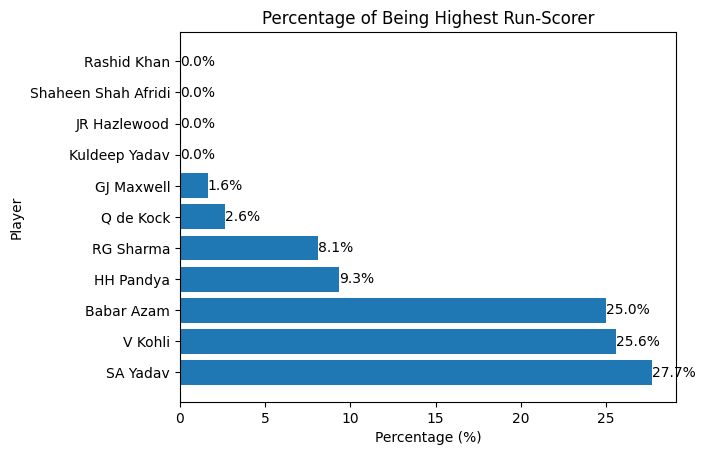

In [73]:
# Simulate match
def simulate_match(Player_details, n_simulations):
    highest_scorer_counts = {player: 0 for player in Player_details['Player']}
    for _ in range(n_simulations):
        # Simulate each player's performance
        runs_scored = np.zeros(len(Player_details))
        for i, player in enumerate(Player_details['Player']):
            Exp_runs_per_ball = Player_details.loc[i, 'Exp_runs_per_ball']
            avg_balls_faced_adj	 = Player_details.loc[i, 'avg_balls_faced_adj']
            # Simulate runs scored by the player
            balls_faced = np.random.randint(1, int(avg_balls_faced_adj * 2))  # Simulate number of balls faced
            adjusted_runs = np.random.normal(Exp_runs_per_ball, scale=5) # Adding randomness
            runs_scored[i] = ((Exp_runs_per_ball)**1.2) * ((balls_faced)**0.9) # giving more weightage to runsperball
        # Identify the highest scorer
        highest_scorer_index = np.argmax(runs_scored)
        highest_scorer = Player_details.loc[highest_scorer_index, 'Player']
        highest_scorer_counts[highest_scorer] += 1
    # Calculate probability of each player being the highest run-scorer
    total_simulations = n_simulations
    player_probabilities = {player: count / total_simulations for player, count in highest_scorer_counts.items()}
    return player_probabilities
# Run Monte Carlo simulation
n_simulations = 10000
player_probabilities = simulate_match(Player_details, n_simulations)
# Print player probabilities
for player, probability in player_probabilities.items():
    print(f"Player: {player}, Probability: {probability}")
# Sort probabilities in ascending order
sorted_probabilities = sorted(player_probabilities.items(), key=lambda x: x[1])
# Extract player names and probabilities
players = [player for player, _ in sorted_probabilities]
probabilities = [probability * 100 for _, probability in sorted_probabilities]
# Create bar plot
plt.barh(players, probabilities)
# Set plot title and labels
plt.title('Percentage of Being Highest Run-Scorer')
plt.xlabel('Percentage (%)')
plt.ylabel('Player')
# Add percentage labels on bars
for i, probability in enumerate(probabilities):
    plt.text(probability, i, f"{probability:.1f}%", va='center')
# Reverse y-axis to display names from down to up
plt.gca().invert_yaxis()
# Display plot
plt.show()

**10. Conclusion: Surely more data for some of the players would have surely
helped to model their probabilities better. Also, assuming runs scored follow gaussian distribution might have not helped the cause, trying to model tail dependencies with copulas could be a solution.**